In [ ]:

!pip install -U layoutparser

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-hzsy1jik/detectron2_4a4ed9b231504b55890c39b46a87b87d
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-hzsy1jik/detectron2_4a4ed9b231504b55890c39b46a87b87d
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached fvcore-0.1.3.post20210317.tar.gz (47 kB)
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 112 kB 32.1 MB/s 
  Created wheel for detectron2: filename=detectron2-0.4-cp37-cp37m-linux_x86_64.whl size=5160876 sha256=ce3b4c7959222c831b23c778b9d7994035ca40d93a9bf4a3486524874139aabb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pue0w_9l/wheels/87/3f/26/dc45098d34763c9dc05ea3ab35c6dec6e9e8c16ac741efb741
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58543 sha256=b6bbe4

In [ ]:

!pip install layoutparser[ocr]

In [ ]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


In [ ]:
%cd layout-parser/

/content/layout-parser


In [ ]:
import cv2
image = cv2.imread("/content/IR-M-S-8890.jpg")
image = image[..., ::-1]

config.yaml?dl=1: 8.19kB [00:01, 4.12kB/s]
model_final.pth?dl=1: 330MB [00:06, 49.3MB/s]                           
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_

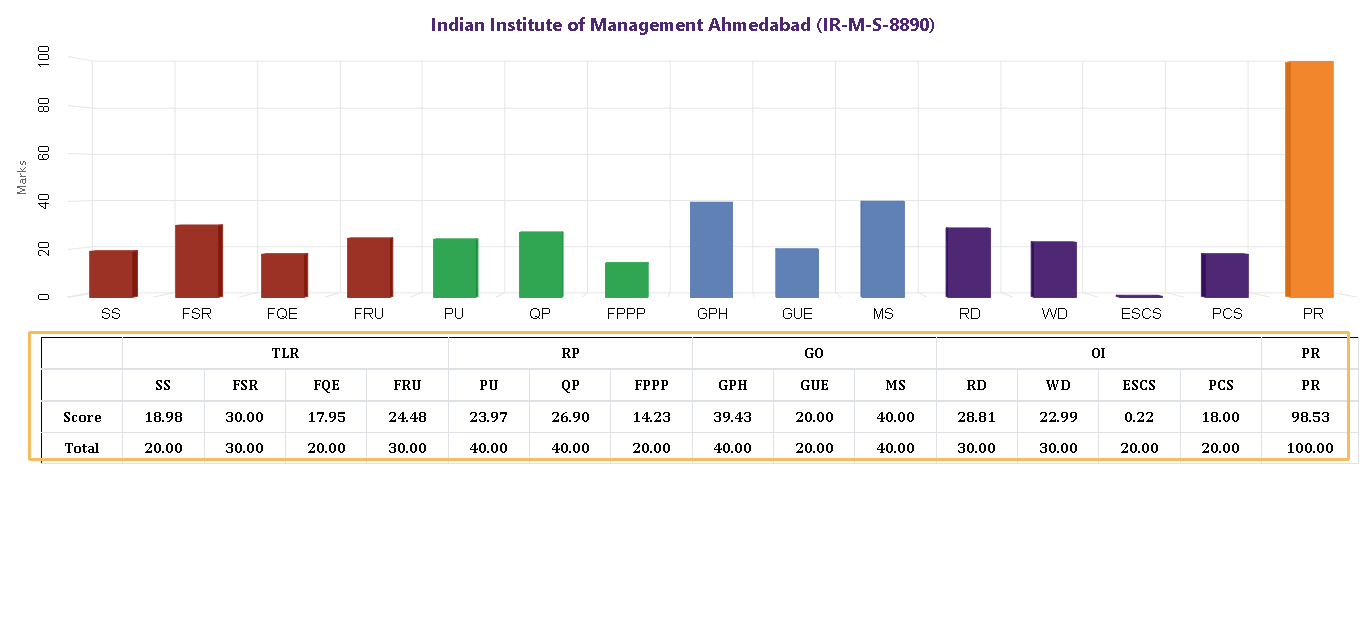

In [ ]:

import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_50_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.9],
                                 label_map={0: "Table"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [ ]:
print( image.shape )

(625, 1366, 3)


In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=29.46224021911621, y_1=332.3977966308594, x_2=1348.3160400390625, y_2=459.7041931152344), text=None, id=None, type=Table, parent=None, next=None, score=0.9374306201934814)], page_data={})

In [ ]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [ ]:
figure_blocks

Layout(_blocks=[], page_data={})

In [ ]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [ ]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

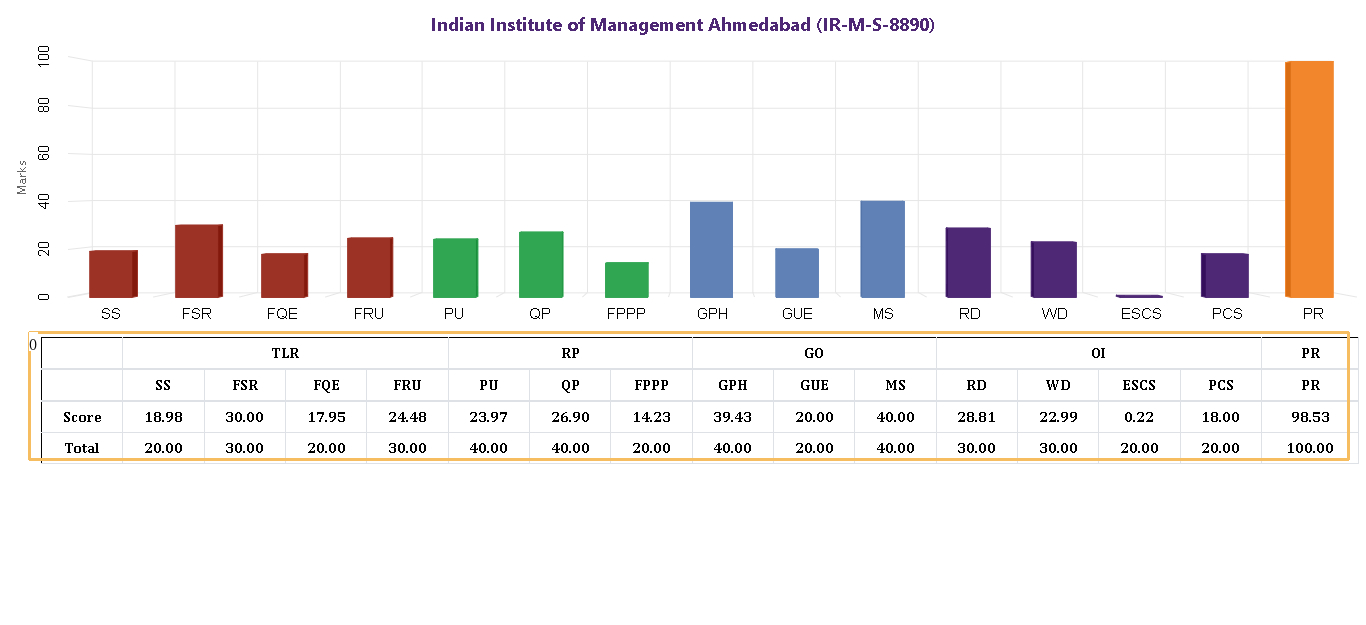

In [ ]:
 
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (19.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)


NameError: ignored

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

NameError: ignored

In [ ]:
text_blocks.get_texts()

[' \n\nss\n\n18.98\n\n20.00\n\nFSR\n\n30.00\n\n30.00\n\nTLR\n\nFQE\n17.95\n\n20.00\n\nFRU\n\n24.48\n\n30.00\n\nPU\n\n23.97\n\n40.00\n\nRP\nee\n26.90\n\n40.00\n\nFPPP\n\n14.23\n\n20.00\n\nGPH\n\n39.43\n\n40.00\n\nGo\n\nGUE\n\n20.00\n\n20.00\n\nMS\n\n40.00\n\n40.00\n\nRD\n\n28.81\n\n30.00\n\nwD\n\n22.99\n\n30.00\n\nol\n\nESCS\n\n0.22\n\n20.00\n\nPCS\n\n18.00\n\n20.00\n\nPR\n\nPR\n\n98.53\n\n100.00\n\x0c']

In [ ]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=29.46224021911621, y_1=332.3977966308594, x_2=1348.3160400390625, y_2=459.7041931152344), text= 

ss

18.98

20.00

FSR

30.00

30.00

TLR

FQE
17.95

20.00

FRU

24.48

30.00

PU

23.97

40.00

RP
ee
26.90

40.00

FPPP

14.23

20.00

GPH

39.43

40.00

Go

GUE

20.00

20.00

MS

40.00

40.00

RD

28.81

30.00

wD

22.99

30.00

ol

ESCS

0.22

20.00

PCS

18.00

20.00

PR

PR

98.53

100.00
, id=0, type=Table, parent=None, next=None, score=0.9374306201934814)


In [ ]:
!pip install spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

     |████████████████████████████████| 42 kB 890 kB/s 
     |████████████████████████████████| 2.6 MB 21.9 MB/s 
     |████████████████████████████████| 456 kB 82.2 MB/s 
     |████████████████████████████████| 998 kB 79.1 MB/s 
     |████████████████████████████████| 5.9 MB 17.8 MB/s 
     |████████████████████████████████| 623 kB 66.1 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 10.1 MB 50.2 MB/s 
     |████████████████████████████████| 895 kB 52.0 MB/s 
     |████████████████████████████████| 3.3 MB 51.3 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      

In [ ]:
!pip install click==7.1.1

     |████████████████████████████████| 82 kB 1.0 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


In [ ]:

import spacy
nlp = spacy.load("en_core_web_trf")

In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)

' \n\nss\n\n18.98\n\n20.00\n\nFSR\n\n30.00\n\n30.00\n\nTLR\n\nFQE\n17.95\n\n20.00\n\nFRU\n\n24.48\n\n30.00\n\nPU\n\n23.97\n\n40.00\n\nRP\nee\n26.90\n\n40.00\n\nFPPP\n\n14.23\n\n20.00\n\nGPH\n\n39.43\n\n40.00\n\nGo\n\nGUE\n\n20.00\n\n20.00\n\nMS\n\n40.00\n\n40.00\n\nRD\n\n28.81\n\n30.00\n\nwD\n\n22.99\n\n30.00\n\nol\n\nESCS\n\n0.22\n\n20.00\n\nPCS\n\n18.00\n\n20.00\n\nPR\n\nPR\n\n98.53\n\n100.00\n\x0c'

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

In [ ]:
print("\n\nss\n\n18.98\n\n20.00\n\nFSR\n\n30.00\n\n30.00\n\nTLR\n\nFQE\n17.95\n\n20.00\n\nFRU\n\n24.48\n\n30.00\n\nPU\n\n23.97\n\n40.00\n\nRP\nee\n26.90\n\n40.00\n\nFPPP\n\n14.23\n\n20.00\n\nGPH\n\n39.43\n\n40.00\n\nGo\n\nGUE\n\n20.00\n\n20.00\n\nMS\n\n40.00\n\n40.00\n\nRD\n\n28.81\n\n30.00\n\nwD\n\n22.99\n\n30.00\n\nol\n\nESCS\n\n0.22\n\n20.00\n\nPCS\n\n18.00\n\n20.00\n\nPR\n\nPR\n\n98.53\n\n100.00\n\x0c")



ss

18.98

20.00

FSR

30.00

30.00

TLR

FQE
17.95

20.00

FRU

24.48

30.00

PU

23.97

40.00

RP
ee
26.90

40.00

FPPP

14.23

20.00

GPH

39.43

40.00

Go

GUE

20.00

20.00

MS

40.00

40.00

RD

28.81

30.00

wD

22.99

30.00

ol

ESCS

0.22

20.00

PCS

18.00

20.00

PR

PR

98.53

100.00

